## SEIR Simulation 

In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# load Origin-Destination matrices
pkl_file = open('data/data_municipalities/od_municipalities.pkl', 'rb') # change to your desired directory
OD_matrices = pkl.load(pkl_file)
pkl_file.close()

print(OD_matrices.shape)

(84, 356, 356)


In [3]:
kommunenavn = pd.read_csv("data/data_municipalities/Kommunenummer_navn_2020.csv", delimiter=",").drop_duplicates()
kommunenavn.rename(columns={"Kommunenr. 2020": "kommunenummer", "Kommunenavn 2020": "kommunenavn"}, inplace=True)
kommunenavn.kommunenummer = kommunenavn.kommunenummer.astype(int)

# create population 
kommunenummer_befolkning = pd.read_csv("data/data_municipalities/Folkemengde_kommuner.csv", delimiter=";", skiprows=1)
kommune_id = []
for id_name in kommunenummer_befolkning.region.str.split(" "):
    kommune_id.append(int(id_name[0]))
kommunenummer_befolkning["kommunenummer"] = kommune_id

kommunenummer_befolkning = kommunenummer_befolkning[["kommunenummer", "Befolkning per 1.1. (personer) 2020"]].rename(columns={ "Befolkning per 1.1. (personer) 2020": "befolkning"})

In [4]:
befolkning = pd.merge(kommunenummer_befolkning, kommunenavn, on='kommunenummer', sort=True)

In [5]:
befolkningsarray = befolkning.befolkning.to_numpy(dtype='float64')
pop = np.asarray([befolkningsarray for _ in range(84)])

In [6]:
print(len(befolkningsarray))

356


In [7]:
# Set up model 
%run virus-sim.py  # Call python files in same directory

r = OD_matrices.shape[0]  # Simulation period (e.g 84)
n = pop.shape[1]          # Number of counties (e.g 11)
N = sum(befolkningsarray) # Total population (e.g 5367580)
initialInd = [0]          # Initial index of counties infected
initial = np.zeros(n)
initial[initialInd] = 50  # Number of infected people in each of the initial counties infected

model = Param(R0=2.4, DE= 5.6 * 12, DI= 5.2 * 12, I0=initial, HospitalisationRate=0.1, eff=0.95, HospitalIters=15*12) # multiply by 12 as one day consists of 12 2-hours periods 

In [8]:
%run div.py
v = 'data/data_municipalities/vaccines_municipalities.pkl'
m = generate_vaccine_matrix(84, 356)
write_pickle(v, m)
# load vaccine schedule
pkl_file = open('data/data_municipalities/vaccines_municipalities.pkl', 'rb')
vacc = pkl.load(pkl_file)
pkl_file.close()
print(vacc.shape)

(84, 356)


In [9]:
# run simulation
%run virus-sim.py

alphas = [np.ones(OD_matrices.shape) for x in range(4)]  # One == no quarantene influence. Multiplied by real flow.
iterations = 3000                   # Number of simulations
res = {}                            # Dictionary with results for different cases 
inf = 50                            # Number of random infections
res['baseline'] = seir(model, pop, OD_matrices, alphas, iterations, inf, vacc)


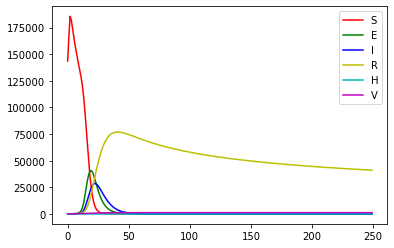

In [10]:
# run simulation
%run virus-sim.py

seir_plot_one_cell(res['baseline'][1], 2)

In [11]:
# Print hospitalized information
print("Max number of hospitalised people: ", int(res["baseline"][0][:,4].max()))
print("Day with max hospitalised people: ", int(res["baseline"][0][:,4].argmax()/12)) # Divide by

Max number of hospitalised people:  97321
Day with max hospitalised people:  27


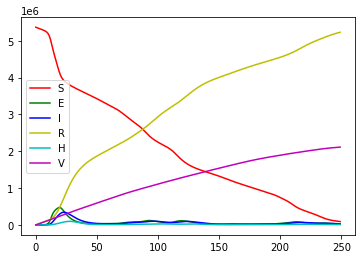

In [12]:
def seir_plot(res):
    """ Plots the epidemiological curves
    Parameters:
    res: [3D array, compartment_id]
    """
    plt.plot(res[::12, 0], color='r', label='S')
    plt.plot(res[::12, 1], color='g', label='E')
    plt.plot(res[::12, 2], color='b', label='I')
    plt.plot(res[::12, 3], color='y', label='R')
    plt.plot(res[::12, 4], color='c', label='H')
    plt.plot(res[::12, 5], color='m', label='V')
    plt.legend()
    plt.show()
    
seir_plot(res["baseline"][0])

## Spatial Visualisation

In [13]:
# import libraries
import pandas as pd
import geopandas as gpd
# import contextily as ctx # Is not installed with current .yml file 
import fiona as fi
from pyproj import CRS

In [14]:
kommuner = pd.read_json('data/data_municipalities/Basisdata_0000_Norge_25833_Kommuner_GEOJSON.geojson')
epsg_kommune = int(kommuner["administrative_enheter.kommune"].loc["crs"]["properties"]["name"].split(":")[1]) # epsg for kartverket sin data
crs_kommune = CRS.from_epsg(epsg_kommune)

In [15]:
# Load geojson data
%run div.py

if False: # Set to False if you have a norge_geojson.pkl in your data folder

    norge_geojson = gpd.read_file("data/data_municipalities/Basisdata_0000_Norge_25833_Kommuner_GEOJSON.geojson", layer='administrative_enheter.kommune')

    write_pickle('data/data_municipalities/norge_geojson.pkl', norge_geojson)
else:
    norge_geojson = read_pickle('data/data_municipalities/norge_geojson.pkl')

In [16]:
# Ensure right epsg
norge_geojson.crs = {'init':f'epsg:{epsg_kommune}'}
norge_geojson.crs = crs_kommune
norge_geojson.kommunenummer = norge_geojson.kommunenummer.astype(int)
norge_geojson.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 363 entries, 0 to 362
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   objtype                   363 non-null    object  
 1   samiskforvaltningsomrade  350 non-null    object  
 2   lokalid                   363 non-null    object  
 3   navnerom                  363 non-null    object  
 4   versjonid                 363 non-null    object  
 5   datafangstdato            0 non-null      object  
 6   oppdateringsdato          363 non-null    object  
 7   datauttaksdato            363 non-null    object  
 8   opphav                    0 non-null      object  
 9   kommunenummer             363 non-null    int64   
 10  navn                      363 non-null    object  
 11  geometry                  363 non-null    geometry
dtypes: geometry(1), int64(1), object(10)
memory usage: 34.2+ KB


In [17]:

kommuner_geometry = pd.merge(norge_geojson, befolkning, on='kommunenummer', sort=True).reset_index().drop_duplicates(["kommunenummer"])
kommuner_geometry.index = kommuner_geometry.kommunenummer
kommuner_geometry = kommuner_geometry[["kommunenavn", "befolkning", "geometry"]]
kommuner_geometry.head()

,kommunenavn,befolkning,geometry
kommunenummer,,,
301,OSLO,693494,"POLYGON ((253222.080 6658210.130, 253240.670 6..."
1101,EIGERSUND,14811,"POLYGON ((-32368.950 6519591.960, -32374.980 6..."
1103,STAVANGER,143574,"POLYGON ((-42633.160 6593087.740, -40878.870 6..."
1106,HAUGESUND,37357,"POLYGON ((-69037.300 6632413.420, -63419.960 6..."
1108,SANDNES,79537,"POLYGON ((-1895.270 6572773.840, -4840.330 657..."


In [18]:
norge_geojson.crs

<Projected CRS: EPSG:25833>
Name: ETRS89 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 12°E and 18°E: Austria; Denmark - offshore and offshore; Germany - onshore and offshore; Norway including Svalbard - onshore and offshore.
- bounds: (12.0, 46.4, 18.01, 84.01)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [19]:
# Uncomment when ctx is used

#norge_geojson_3857 = norge_geojson.to_crs(epsg=3857)  # Convert to epsg=3857 to use contextily
#west, south, east, north = norge_geojson_3857.unary_union.bounds
west, south, east, north = kommuner_geometry.unary_union.bounds

In [20]:
# declare baseline array storing the dynamics of the compartments 
baseline = res['baseline'][1][::12, :, :]
print(baseline.shape)
#print(baseline)

(250, 6, 356)
[[[ 6.93444000e+005  1.48110000e+004  1.43574000e+005 ...
    9.26000000e+002  2.22100000e+003  1.01580000e+004]
  [ 0.00000000e+000  0.00000000e+000  0.00000000e+000 ...
    0.00000000e+000  0.00000000e+000  0.00000000e+000]
  [ 5.00000000e+001  0.00000000e+000  0.00000000e+000 ...
    0.00000000e+000  0.00000000e+000  0.00000000e+000]
  [ 0.00000000e+000  0.00000000e+000  0.00000000e+000 ...
    0.00000000e+000  0.00000000e+000  0.00000000e+000]
  [ 0.00000000e+000  0.00000000e+000  0.00000000e+000 ...
    0.00000000e+000  0.00000000e+000  0.00000000e+000]
  [ 0.00000000e+000  0.00000000e+000  0.00000000e+000 ...
    0.00000000e+000  0.00000000e+000  0.00000000e+000]]

 [[ 3.33112061e+005  2.76038757e+005  1.66972316e+005 ...
    3.07765068e+003  4.64498423e+003  5.39704031e+003]
  [ 2.60915962e+001  4.85536760e+001  1.95575873e+001 ...
    0.00000000e+000  0.00000000e+000  0.00000000e+000]
  [ 2.00642262e+001  1.62071867e+001  7.74267467e+000 ...
    0.00000000e+000  0

In [21]:
# declare hopsitalisation array storing the dynamics of the hospitalised 
hosp = res['baseline'][0][::12, 4]
print(hosp.shape)
#print(hosp)

(250,)
[0.00000000e+00 3.89969695e-01 2.88004701e+00 7.91540744e+00
 1.64798159e+01 3.10057936e+01 5.66771311e+01 1.04640925e+02
 1.99410203e+02 3.95325720e+02 8.10574252e+02 1.68492322e+03
 3.42794390e+03 6.51397346e+03 1.11262661e+04 1.69955451e+04
 2.37398989e+04 3.11099529e+04 3.89717124e+04 4.72266634e+04
 5.56760059e+04 6.39631171e+04 7.17333485e+04 7.87581959e+04
 8.49133331e+04 9.00944799e+04 9.41181562e+04 9.66481332e+04
 9.72859142e+04 9.59197145e+04 9.28835250e+04 8.86162821e+04
 8.34156404e+04 7.74581857e+04 7.08785456e+04 6.39052717e+04
 5.69177803e+04 5.02840056e+04 4.42292103e+04 3.88418866e+04
 3.41242403e+04 3.00339902e+04 2.65099240e+04 2.34866474e+04
 2.09016289e+04 1.86977606e+04 1.68241011e+04 1.52362650e+04
 1.38961698e+04 1.27712667e+04 1.18337880e+04 1.10602516e+04
 1.04308479e+04 9.92886348e+03 9.53981896e+03 9.25042731e+03
 9.04765531e+03 8.91817489e+03 8.84839546e+03 8.82502271e+03
 8.83586803e+03 8.87058666e+03 8.92111598e+03 8.98190829e+03
 9.05000119e+03 9

In [23]:
max_exp_ind = np.where(df.exposed_per_100k == df.exposed_per_100k.max())[0].item()
max_exp_val = df.exposed_per_100k.max()
print(max_exp_ind, max_exp_val)

7142 4713078.3451601565


In [24]:
# find maximum hospitalisation value to make sure the color intensities in the animation are anchored against it
#max_exp_ind = np.where(baseline[:, 1, :] == baseline[:, 1, :].max())[0].item()
#max_exp_val = baseline[:, 1, :].max()
#print(max_exp_ind, max_exp_val)

In [31]:
params = {"axes.labelcolor":"slategrey"}
plt.rcParams.update(params)
cmap = plt.cm.get_cmap("Blues")
blue = cmap(200)

from tqdm import tqdm

# Used for colorbar 
max_exp_val = baseline[:, 1, :].max()
min_exp_val = baseline[:, 1, :].min()
h = ax.imshow(np.random.uniform(low=min_exp_val, high=max_exp_val, size=(10,10)), cmap=new_cmap)

for time_step in tqdm(range(1,250)):
    
    kommuner_geometry['exposed_per_100k' + str(time_step)] = 100000*baseline[time_step-1, 1, :]/befolkning.befolkning.to_numpy(int)
    #print(kommuner_geometry[['kommunenavn', 'exposed_per_100k']].head())
    #plot
    fig, ax = plt.subplots(figsize=(14,14), dpi=72)
    #norge_geojson_3857.loc[norge_geojson_3857.index==84, 'exposed'] = max_exp_val + 1
    kommuner_geometry.plot(ax=ax, facecolor='none', edgecolor='gray', alpha=0.5, linewidth=0.5, zorder=2)
    kommuner_geometry.plot(ax=ax, column='exposed_per_100k', cmap=new_cmap, zorder=3)
    # add background
    # ctx.add_basemap(ax, attribution="", source=ctx.sources.ST_TONER_LITE, zoom='auto', alpha=0.6)
    
    ax.set_xlim(west, east)
    ax.set_ylim(south, north)
    ax.axis('off')
    plt.tight_layout()

    # Add colourbar
    plt.colorbar(mappable=h)
    
    inset_ax = fig.add_axes([0.4, 0.14, 0.37, 0.27])
    inset_ax.patch.set_alpha(0.5)
    
    inset_ax.plot(baseline[:time_step, 0].sum(axis=1), label="susceptible", color=blue, ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(baseline[:time_step, 1].sum(axis=1), label="exposed", color='g', ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(baseline[:time_step, 2].sum(axis=1), label="infectious", color='r', ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(baseline[:time_step, 3].sum(axis=1), label="recovered", color='y', ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(hosp[:time_step], label="hospitalised", color='purple', ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(baseline[:time_step, 5].sum(axis=1), label="vaccinated", color='m', ls='-', lw=1.5, alpha=0.8)
    
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 0].sum(), color=blue, s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 1].sum(), color='g', s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 2].sum(), color='r', s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 3].sum(), color='y', s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), hosp[(time_step-1)], color='purple', s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 5].sum(), color='m', s=50, alpha=0.2)
    
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 0].sum(), color=blue, s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 1].sum(), color='g', s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 2].sum(), color='r', s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 3].sum(), color='y', s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), hosp[(time_step-1)], color='purple', s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 5].sum(), color='m', s=20, alpha=0.8)
    
    inset_ax.fill_between(np.arange(0, time_step), np.maximum(baseline[:time_step, 0].sum(axis=1), \
                                                             baseline[:time_step, 3].sum(axis=1)), alpha=0.035, color='r')
    inset_ax.plot([time_step, time_step], [0, max(baseline[(time_step-1), 0].sum(), \
                                              baseline[(time_step-1), 3].sum())], ls='--', lw=0.7, alpha=0.8, color='r')
    
    inset_ax.set_ylabel('Population', size=18, alpha=1, rotation=90)
    inset_ax.set_xlabel('Days', size=18, alpha=1)
    inset_ax.yaxis.set_label_coords(-0.15, 0.55)
    inset_ax.tick_params(direction='in', size=10)
    inset_ax.set_xlim(-4, 254)
    inset_ax.set_ylim(-24000, 6024000)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    inset_ax.grid(alpha=0.4)
    
    inset_ax.spines['right'].set_visible(False)
    inset_ax.spines['top'].set_visible(False)
    
    inset_ax.spines['left'].set_color('darkslategrey')
    inset_ax.spines['bottom'].set_color('darkslategrey')
    inset_ax.tick_params(axis='x', colors='darkslategrey')
    inset_ax.tick_params(axis='y', colors='darkslategrey')
    plt.legend(prop={'size':14, 'weight':'light'}, framealpha=0.5)
    plt.title("Norway Covid-19 spreading on day: {}".format(time_step), fontsize=18, color= 'dimgray')
    plt.savefig("plots/plots_municipalities/flows_{}.jpg".format(time_step), dpi=fig.dpi)
    plt.close()

  7%|▋         | 18/249 [01:00<13:02,  3.39s/it]


KeyboardInterrupt: 

In [194]:
import re

def sort_in_order( l ):
    """ sorts a given iterable
    
    l : iterable to be sorted"""
    
    convert = lambda text: int(text) if text.isdigit() else text
    alphanumeric_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanumeric_key)

from os import listdir

filenames = listdir("plots/plots_municipalities/")
filenames = sort_in_order(filenames)
print(filenames)

['flows_1.jpg', 'flows_2.jpg', 'flows_3.jpg', 'flows_4.jpg', 'flows_5.jpg', 'flows_6.jpg', 'flows_7.jpg', 'flows_8.jpg', 'flows_9.jpg', 'flows_10.jpg', 'flows_11.jpg', 'flows_12.jpg', 'flows_13.jpg', 'flows_14.jpg', 'flows_15.jpg', 'flows_16.jpg', 'flows_17.jpg', 'flows_18.jpg', 'flows_19.jpg', 'flows_20.jpg', 'flows_21.jpg', 'flows_22.jpg', 'flows_23.jpg', 'flows_24.jpg', 'flows_25.jpg', 'flows_26.jpg', 'flows_27.jpg', 'flows_28.jpg', 'flows_29.jpg', 'flows_30.jpg', 'flows_31.jpg', 'flows_32.jpg', 'flows_33.jpg', 'flows_34.jpg', 'flows_35.jpg', 'flows_36.jpg', 'flows_37.jpg', 'flows_38.jpg', 'flows_39.jpg', 'flows_40.jpg', 'flows_41.jpg', 'flows_42.jpg', 'flows_43.jpg', 'flows_44.jpg', 'flows_45.jpg', 'flows_46.jpg', 'flows_47.jpg', 'flows_48.jpg', 'flows_49.jpg', 'flows_50.jpg', 'flows_51.jpg', 'flows_52.jpg', 'flows_53.jpg', 'flows_54.jpg', 'flows_55.jpg', 'flows_56.jpg', 'flows_57.jpg', 'flows_58.jpg', 'flows_59.jpg', 'flows_60.jpg', 'flows_61.jpg', 'flows_62.jpg', 'flows_63.jpg', 

In [195]:
import imageio
from tqdm import tqdm
with imageio.get_writer('gifs/gifs_municipalities/Covid_19_municipalities.gif', mode='I', fps=4) as writer:
    for filename in tqdm(filenames):
        image = imageio.imread('plots/plots_municipalities/{}'.format(filename))
        writer.append_data(image)

100%|██████████| 249/249 [00:52<00:00,  4.71it/s]
